# How to (not) predict Bitcoin price (Episode I)

Hi! In this new entry I wanted to show you a quick project I was trying to carry to learn about *Recurrent Neural Networks*, specifically about *Long-short Term Memories*.

First of all, this must not be taken as financial advise, this is just an exercise to learn how to predict Multivariate Time Series with Deep Learning techniques. I have 0 knowledge on stoke markets and how they work, and I just wanted to see if a blackbox algorithm like a neural network can make a newbie like me rich in a couple of days (it took me that time to deploy this simple model). *Spoiler: it didn't make me rich*


Bitcoin is known to be a very complicated time series, with many external factors (even manipulation from some sectors and fake volumes by exchanges) and a huge variance (it can multiply its price by 2 in 24h). I have to say I expect nothing spectacular from this excercise, since it's just a homemade solution in just one day with an old laptop which means I can't test many models.

Let's find out how I trained the net.

## Data Preprocessing

First of all, we need to do a bit of preprocessing, since Change% is treated like a string and Volume is expressed in "Thousands" with a k at the end (4k = 4000, 4M=4000k). Therefore, we need to strip that last letter and convert both observations consequently

In [1]:
import pandas as pd

import numpy as np

data=pd.read_csv("bitcoinhist.csv",thousands=",")

data=data.iloc[::-1]
data=data.iloc[:,1:]
data=data.reset_index(drop=True)
data["Change %"]=[float(i.strip("%"))/100 for i in data["Change %"]]

volaux=np.zeros(len(data["Vol."]))
for k in range(len(data["Vol."])):
    try:
        obs=data.iloc[k,4]
        multiplier=1
        if obs[-1]=="M":
            multiplier=1000

        volaux[k]=float(obs[:-1])*multiplier
            
    except:
        volaux[k]=(volaux[k-1]+volaux[k-2])/2

data["Vol."]=volaux
data

,Price,Open,High,Low,Vol.,Change %
0,0.3,0.3,0.3,0.3,4.94,0.0000
1,0.3,0.3,0.3,0.3,15.44,0.0000
2,0.3,0.3,0.3,0.3,18.61,0.0000
3,0.3,0.3,0.3,0.3,2.54,0.0000
4,0.3,0.3,0.3,0.3,1.45,0.0000
...,...,...,...,...,...,...
3314,8405.1,8678.5,8687.3,8309.6,722.67,-0.0315
3315,8439.9,8404.9,8522.0,8242.6,617.02,0.0041
3316,8341.6,8439.9,8447.6,8277.2,444.00,-0.0117
3317,8607.8,8341.6,8607.8,8304.9,468.34,0.0319


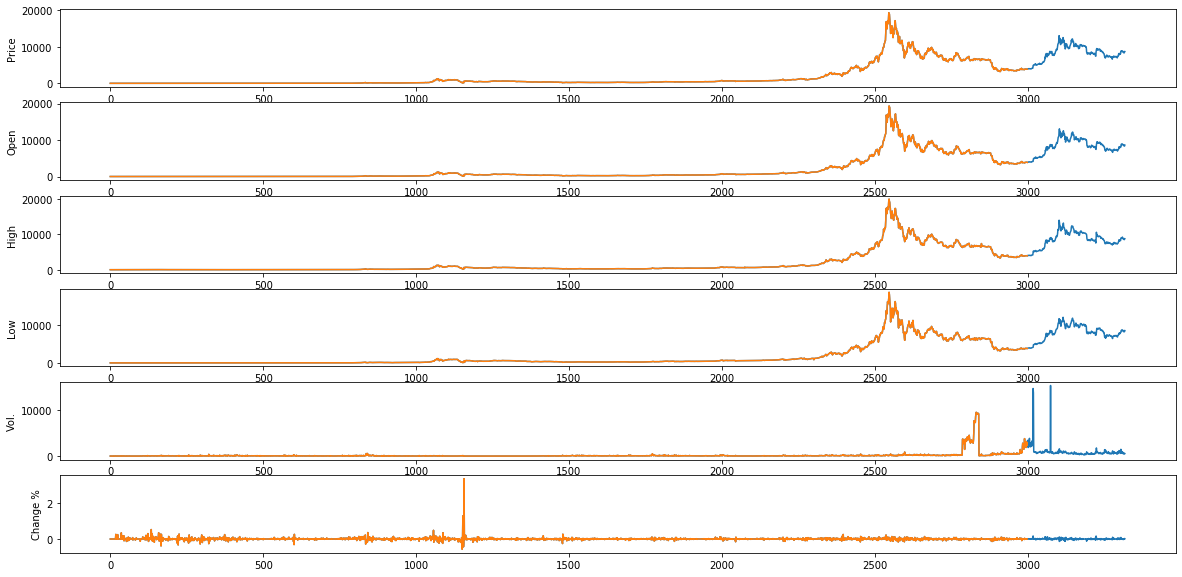

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X=np.asarray(data)
X_train=X[0:3000,:]
X_test=X[3000:,:]



fig, axes = plt.subplots(6,figsize=(20,10))

for s in range(len(axes)):
    axes[s].plot(X[:,s])
    axes[s].set_ylabel(data.columns[s])
    axes[s].plot(X_train[:,s])

I splitted my data in train and test, so I have some data that the net has never seen and would give me an accurate intuition of how it's performing

## TimeSeriesGenerator


Keras provides an utility for sequence segmentation. With TimeseriesGenerator we can just pass the series and tell it the length of the window (previous values) to predict the next ones.

The reason to ask for a 128 batch size is because powers of two are more computationally efficient, since computers memories are structured in bits/bytes

In [3]:
from keras.preprocessing.sequence import TimeseriesGenerator

window=7
series_train = TimeseriesGenerator(X_train, X_train, length=window, batch_size=128)

Using TensorFlow backend.


# Model 

I decided to go with this architecture after some trials, but in deep learning there is no solid guide to choose the architecture but trial and error.

Basically i stacked two layers of LSTM cells with Dropout (regularization technique that blocks some neurons while training randomly to avoid overfitting. This prevents that some neurons become so important that the rest won't get to train). I used MAE as my loss function, since it's a very popular metric in stock analysis

In [4]:
from keras.layers import LSTM,Dense,TimeDistributed,Dropout
from keras import Sequential
from keras.utils import plot_model


model = Sequential()
model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(window, X.shape[1])))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mean_absolute_error')

It's important to use fit_generator instead of fit when using generators.

In [5]:
model.fit_generator(series_train, steps_per_epoch=len(series_train),epochs=1000)

Epoch 1/1000
24/24 [==============================] - 1s 62ms/step - loss: 523.5249
Epoch 2/1000
24/24 [==============================] - 1s 34ms/step - loss: 316.4357
Epoch 3/1000
24/24 [==============================] - 1s 32ms/step - loss: 209.8142
Epoch 4/1000
24/24 [==============================] - 1s 34ms/step - loss: 185.2092
Epoch 5/1000
24/24 [==============================] - 1s 31ms/step - loss: 198.1806
Epoch 6/1000
24/24 [==============================] - 1s 31ms/step - loss: 217.1682
Epoch 7/1000
24/24 [==============================] - 1s 35ms/step - loss: 212.2856
Epoch 8/1000
24/24 [==============================] - 1s 34ms/step - loss: 146.6208
Epoch 9/1000
24/24 [==============================] - 1s 30ms/step - loss: 160.8000
Epoch 10/1000
24/24 [==============================] - 1s 34ms/step - loss: 193.3070
Epoch 11/1000
24/24 [==============================] - 1s 34ms/step - loss: 187.9930
Epoch 12/1000
24/24 [==============================] - 1s 31ms/step - loss

24/24 [==============================] - 1s 34ms/step - loss: 109.8752
Epoch 98/1000
24/24 [==============================] - 1s 34ms/step - loss: 112.0456
Epoch 99/1000
24/24 [==============================] - 1s 31ms/step - loss: 113.1710
Epoch 100/1000
24/24 [==============================] - 1s 31ms/step - loss: 106.3367
Epoch 101/1000
24/24 [==============================] - 1s 34ms/step - loss: 101.8729
Epoch 102/1000
24/24 [==============================] - 1s 32ms/step - loss: 104.2047
Epoch 103/1000
24/24 [==============================] - 1s 33ms/step - loss: 103.1336
Epoch 104/1000
24/24 [==============================] - 1s 35ms/step - loss: 127.9740
Epoch 105/1000
24/24 [==============================] - 1s 34ms/step - loss: 121.4715
Epoch 106/1000
24/24 [==============================] - 1s 33ms/step - loss: 113.5351
Epoch 107/1000
24/24 [==============================] - 1s 34ms/step - loss: 166.8534
Epoch 108/1000
24/24 [==============================] - 1s 34ms/step - 

24/24 [==============================] - 1s 34ms/step - loss: 160.7787
Epoch 193/1000
24/24 [==============================] - 1s 35ms/step - loss: 106.2646
Epoch 194/1000
24/24 [==============================] - 1s 34ms/step - loss: 101.6685
Epoch 195/1000
24/24 [==============================] - 1s 34ms/step - loss: 133.4089
Epoch 196/1000
24/24 [==============================] - 1s 34ms/step - loss: 87.6406
Epoch 197/1000
24/24 [==============================] - 1s 34ms/step - loss: 166.4741
Epoch 198/1000
24/24 [==============================] - 1s 34ms/step - loss: 116.2737
Epoch 199/1000
24/24 [==============================] - 1s 35ms/step - loss: 155.6855
Epoch 200/1000
24/24 [==============================] - 1s 34ms/step - loss: 112.3538
Epoch 201/1000
24/24 [==============================] - 1s 34ms/step - loss: 113.0869
Epoch 202/1000
24/24 [==============================] - 1s 34ms/step - loss: 93.2073
Epoch 203/1000
24/24 [==============================] - 1s 34ms/step - 

24/24 [==============================] - 1s 35ms/step - loss: 92.2150
Epoch 289/1000
24/24 [==============================] - 1s 34ms/step - loss: 116.2642
Epoch 290/1000
24/24 [==============================] - 1s 34ms/step - loss: 80.4306
Epoch 291/1000
24/24 [==============================] - 1s 35ms/step - loss: 61.7466
Epoch 292/1000
24/24 [==============================] - 1s 34ms/step - loss: 66.5567
Epoch 293/1000
24/24 [==============================] - 1s 35ms/step - loss: 61.4320
Epoch 294/1000
24/24 [==============================] - 1s 35ms/step - loss: 55.3827
Epoch 295/1000
24/24 [==============================] - 1s 34ms/step - loss: 55.2643
Epoch 296/1000
24/24 [==============================] - 1s 34ms/step - loss: 66.7366
Epoch 297/1000
24/24 [==============================] - 1s 36ms/step - loss: 98.0508
Epoch 298/1000
24/24 [==============================] - 1s 34ms/step - loss: 104.8205
Epoch 299/1000
24/24 [==============================] - 1s 35ms/step - loss: 5

24/24 [==============================] - 1s 34ms/step - loss: 44.3386
Epoch 385/1000
24/24 [==============================] - 1s 34ms/step - loss: 52.3796
Epoch 386/1000
24/24 [==============================] - 1s 35ms/step - loss: 53.7167
Epoch 387/1000
24/24 [==============================] - 1s 35ms/step - loss: 91.8869
Epoch 388/1000
24/24 [==============================] - 1s 34ms/step - loss: 86.8354
Epoch 389/1000
24/24 [==============================] - 1s 35ms/step - loss: 178.3312
Epoch 390/1000
24/24 [==============================] - 1s 35ms/step - loss: 299.9997
Epoch 391/1000
24/24 [==============================] - 1s 35ms/step - loss: 69.4752
Epoch 392/1000
24/24 [==============================] - 1s 36ms/step - loss: 55.0966
Epoch 393/1000
24/24 [==============================] - 1s 34ms/step - loss: 52.8759
Epoch 394/1000
24/24 [==============================] - 1s 36ms/step - loss: 46.5666
Epoch 395/1000
24/24 [==============================] - 1s 34ms/step - loss: 4

24/24 [==============================] - 1s 35ms/step - loss: 115.1063
Epoch 481/1000
24/24 [==============================] - 1s 34ms/step - loss: 145.8023
Epoch 482/1000
24/24 [==============================] - 1s 35ms/step - loss: 87.4832
Epoch 483/1000
24/24 [==============================] - 1s 34ms/step - loss: 69.9080
Epoch 484/1000
24/24 [==============================] - 1s 35ms/step - loss: 91.8569
Epoch 485/1000
24/24 [==============================] - 1s 34ms/step - loss: 124.9209
Epoch 486/1000
24/24 [==============================] - 1s 35ms/step - loss: 72.2880
Epoch 487/1000
24/24 [==============================] - 1s 34ms/step - loss: 60.1985
Epoch 488/1000
24/24 [==============================] - 1s 35ms/step - loss: 58.0798
Epoch 489/1000
24/24 [==============================] - 1s 35ms/step - loss: 60.3236
Epoch 490/1000
24/24 [==============================] - 1s 34ms/step - loss: 75.6977
Epoch 491/1000
24/24 [==============================] - 1s 34ms/step - loss: 

24/24 [==============================] - 1s 35ms/step - loss: 126.9971
Epoch 577/1000
24/24 [==============================] - 1s 34ms/step - loss: 134.8142
Epoch 578/1000
24/24 [==============================] - 1s 35ms/step - loss: 126.0866
Epoch 579/1000
24/24 [==============================] - 1s 34ms/step - loss: 126.8310
Epoch 580/1000
24/24 [==============================] - 1s 35ms/step - loss: 136.1841
Epoch 581/1000
24/24 [==============================] - 1s 34ms/step - loss: 152.9664
Epoch 582/1000
24/24 [==============================] - 1s 35ms/step - loss: 133.3134
Epoch 583/1000
24/24 [==============================] - 1s 35ms/step - loss: 161.0146
Epoch 584/1000
24/24 [==============================] - 1s 34ms/step - loss: 171.0047
Epoch 585/1000
24/24 [==============================] - 1s 35ms/step - loss: 167.3382
Epoch 586/1000
24/24 [==============================] - 1s 34ms/step - loss: 181.2174
Epoch 587/1000
24/24 [==============================] - 1s 35ms/step 

24/24 [==============================] - 1s 35ms/step - loss: 108.5670
Epoch 672/1000
24/24 [==============================] - 1s 34ms/step - loss: 95.4124
Epoch 673/1000
24/24 [==============================] - 1s 34ms/step - loss: 91.1165
Epoch 674/1000
24/24 [==============================] - 1s 35ms/step - loss: 149.3623
Epoch 675/1000
24/24 [==============================] - 1s 34ms/step - loss: 153.5854
Epoch 676/1000
24/24 [==============================] - 1s 35ms/step - loss: 125.8911
Epoch 677/1000
24/24 [==============================] - 1s 34ms/step - loss: 111.2025
Epoch 678/1000
24/24 [==============================] - 1s 35ms/step - loss: 141.6459
Epoch 679/1000
24/24 [==============================] - 1s 35ms/step - loss: 158.8478
Epoch 680/1000
24/24 [==============================] - 1s 34ms/step - loss: 131.0447
Epoch 681/1000
24/24 [==============================] - 1s 37ms/step - loss: 115.8225
Epoch 682/1000
24/24 [==============================] - 1s 34ms/step - 

24/24 [==============================] - 1s 34ms/step - loss: 73.8673
Epoch 767/1000
24/24 [==============================] - 1s 34ms/step - loss: 130.6040
Epoch 768/1000
24/24 [==============================] - 1s 35ms/step - loss: 160.4940
Epoch 769/1000
24/24 [==============================] - 1s 35ms/step - loss: 186.1876
Epoch 770/1000
24/24 [==============================] - 1s 35ms/step - loss: 109.5906
Epoch 771/1000
24/24 [==============================] - 1s 35ms/step - loss: 98.2990
Epoch 772/1000
24/24 [==============================] - 1s 35ms/step - loss: 91.8058
Epoch 773/1000
24/24 [==============================] - 1s 35ms/step - loss: 92.2582
Epoch 774/1000
24/24 [==============================] - 1s 35ms/step - loss: 87.3958
Epoch 775/1000
24/24 [==============================] - 1s 35ms/step - loss: 92.8719
Epoch 776/1000
24/24 [==============================] - 1s 35ms/step - loss: 92.7884
Epoch 777/1000
24/24 [==============================] - 1s 35ms/step - loss:

Epoch 862/1000
24/24 [==============================] - 1s 34ms/step - loss: 99.8267
Epoch 863/1000
24/24 [==============================] - 1s 35ms/step - loss: 94.8547
Epoch 864/1000
24/24 [==============================] - 1s 34ms/step - loss: 96.7452
Epoch 865/1000
24/24 [==============================] - 1s 34ms/step - loss: 95.9087
Epoch 866/1000
24/24 [==============================] - 1s 35ms/step - loss: 117.2128
Epoch 867/1000
24/24 [==============================] - 1s 34ms/step - loss: 125.8464
Epoch 868/1000
24/24 [==============================] - 1s 34ms/step - loss: 339.4594
Epoch 869/1000
24/24 [==============================] - 1s 35ms/step - loss: 273.6726
Epoch 870/1000
24/24 [==============================] - 1s 34ms/step - loss: 194.0775
Epoch 871/1000
24/24 [==============================] - 1s 35ms/step - loss: 217.6205
Epoch 872/1000
24/24 [==============================] - 1s 34ms/step - loss: 185.0855
Epoch 873/1000
24/24 [==============================] - 1s

24/24 [==============================] - 1s 34ms/step - loss: 85.3848
Epoch 958/1000
24/24 [==============================] - 1s 35ms/step - loss: 104.3953
Epoch 959/1000
24/24 [==============================] - 1s 35ms/step - loss: 84.1810
Epoch 960/1000
24/24 [==============================] - 1s 35ms/step - loss: 68.3556
Epoch 961/1000
24/24 [==============================] - 1s 35ms/step - loss: 75.0363
Epoch 962/1000
24/24 [==============================] - 1s 35ms/step - loss: 76.0126
Epoch 963/1000
24/24 [==============================] - 1s 35ms/step - loss: 118.9511
Epoch 964/1000
24/24 [==============================] - 1s 36ms/step - loss: 104.2291
Epoch 965/1000
24/24 [==============================] - 1s 35ms/step - loss: 84.6731
Epoch 966/1000
24/24 [==============================] - 1s 35ms/step - loss: 76.2127
Epoch 967/1000
24/24 [==============================] - 1s 36ms/step - loss: 79.7806
Epoch 968/1000
24/24 [==============================] - 1s 34ms/step - loss: 

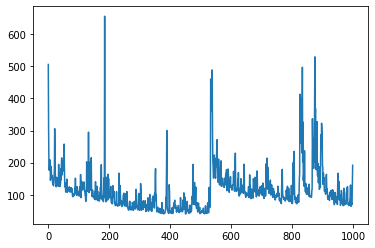

In [6]:
plt.plot(model.history.history["loss"])

The loss function seems to have decreased althought it's kinda bad, it's not a steady descent. Let's see how it fits the time series in the train data

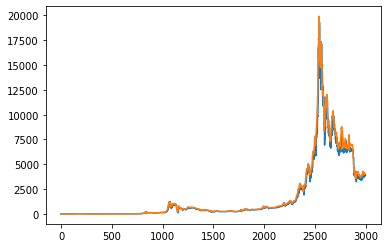

In [7]:
predicted_train=model.predict_generator(series_train)

price_pred_train=predicted_train[:,0]
price=X_train[:,0]
plt.plot(price)
plt.plot(price_pred_train)

Pretty good huh? However, such a good fitting could imply overfitting (we may have trained for too much epochs). Let's use our test data to check if the fitting is that good in unseen data!

## Time to go test

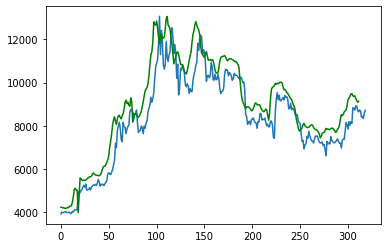

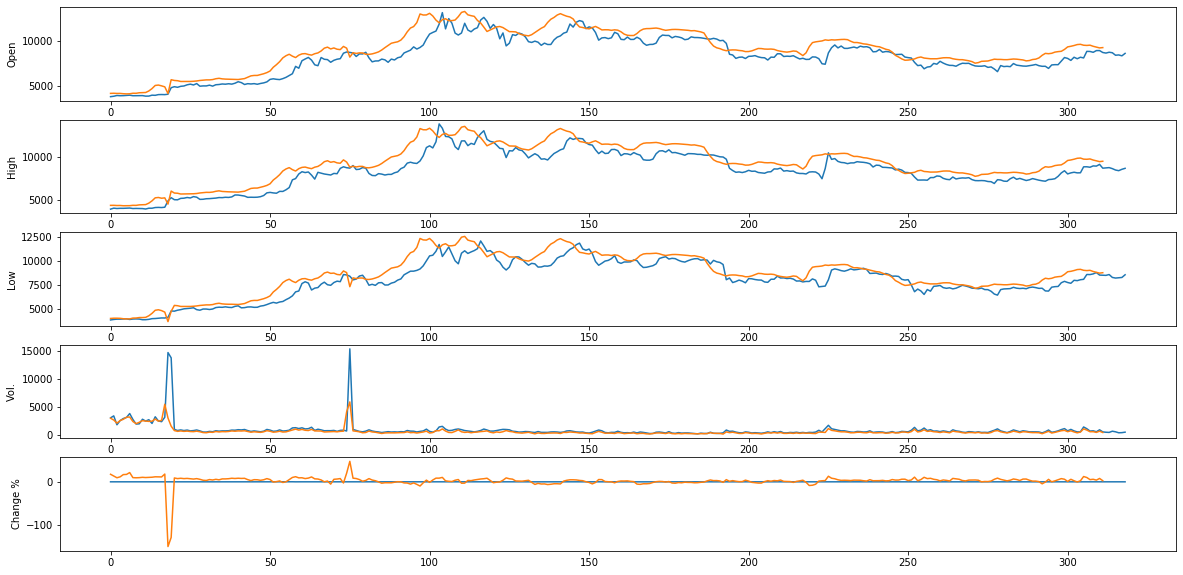

In [48]:
series_test = TimeseriesGenerator(X_test, X_test, length=window, batch_size=128)

predicted_test=model.predict_generator(series_test)
price_pred_test=predicted_test[:,0]
price_test=X_test[:,0]

plt.plot(price_test)
plt.plot(price_pred_test,color="g")

fig, axes = plt.subplots(5,figsize=(20,10))

for s in range(0,len(axes)):
    axes[s].plot(X_test[:,s+1])
    axes[s].set_ylabel(data.columns[s+1])
    axes[s].plot(predicted_test[:,s+1])

Not a bad fit, specially for the price! We gonna be rich! Wait, there is something wrong with this. So easy, I created a really good predictor in my bedroom, why doesn't everyone do this?

This results are a bit tricky. There is not much point in predicting to one day. Some Markovian models work like this (thanks to Alf from DataScienceSpain for the hints around this topic), as the best prediction for tomorrows value is todays value, which gathers a lot of information on the past days. Will I earn some money? Let's make a simulation, starting with 1000$

Text(0, 0.5, 'BTC count')

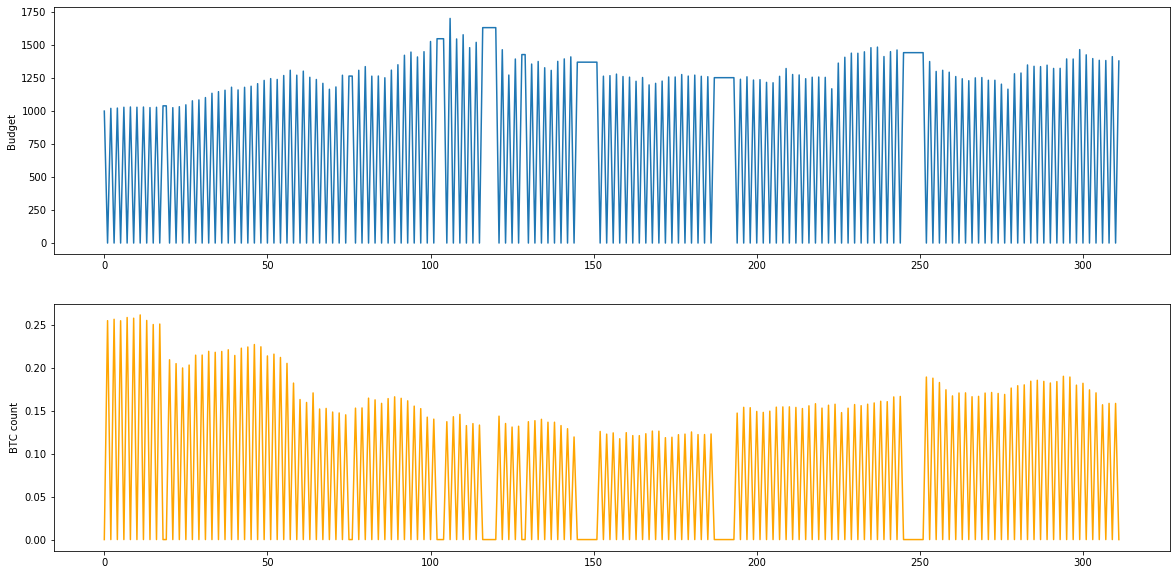

In [33]:
budget=1000
btcs=0
predicted_price=price_pred_test


budget_hist=[budget]
btcs_hist=[btcs]
for tomorrow in range(1,X_test.shape[0]-window):
    today=tomorrow-1
    
    if predicted_price[tomorrow]>price_test[today] and budget>0: #If i predict the price is going up from todays and i have money, we buy some btc
        btcs=budget/price_test[today]
        budget=0
    elif btcs>0: #we sell everything if it's gonna go down
        #print("vendo")
        budget=btcs*price_test[today]
        btcs=0
    budget_hist=budget_hist+[budget]
    btcs_hist=btcs_hist+[btcs]
    
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("BTC count")

In [31]:
print("Ended up with ",btcs_hist[-1]," bitcoins")
print("Ended up with ",budget_hist[-1],"dollars")

Ended up with  0  bitcoins
Ended up with  1379.6490343834798 dollars


In 1000 days, my algorithm only made 379 dollars, which is not that amusing. My best mark was at past 100 days where I made 750$, that means that I had a 1.379 \% profit in 300 days. Not that great

## Let's make it harder, let's predict based on past predictions

What happens if I trust my predictor to try to predict the next days? We will iterate feeding the last prediction as the input for the test data (suppose we don't know the test data, that is yet to come in the future)

In [49]:
last_7pred=np.atleast_2d(predicted_test[-(window+1):,:])

future_predictions=[]
for day in range(X_test.shape[0]):
    pred7_gen=TimeseriesGenerator(last_7pred,last_7pred,length=window,batch_size=1)
    predicted_value=list(model.predict_generator(pred7_gen))
    last_7pred=np.concatenate((last_7pred[1:,:],predicted_value))
    future_predictions=future_predictions+predicted_value


# Full series

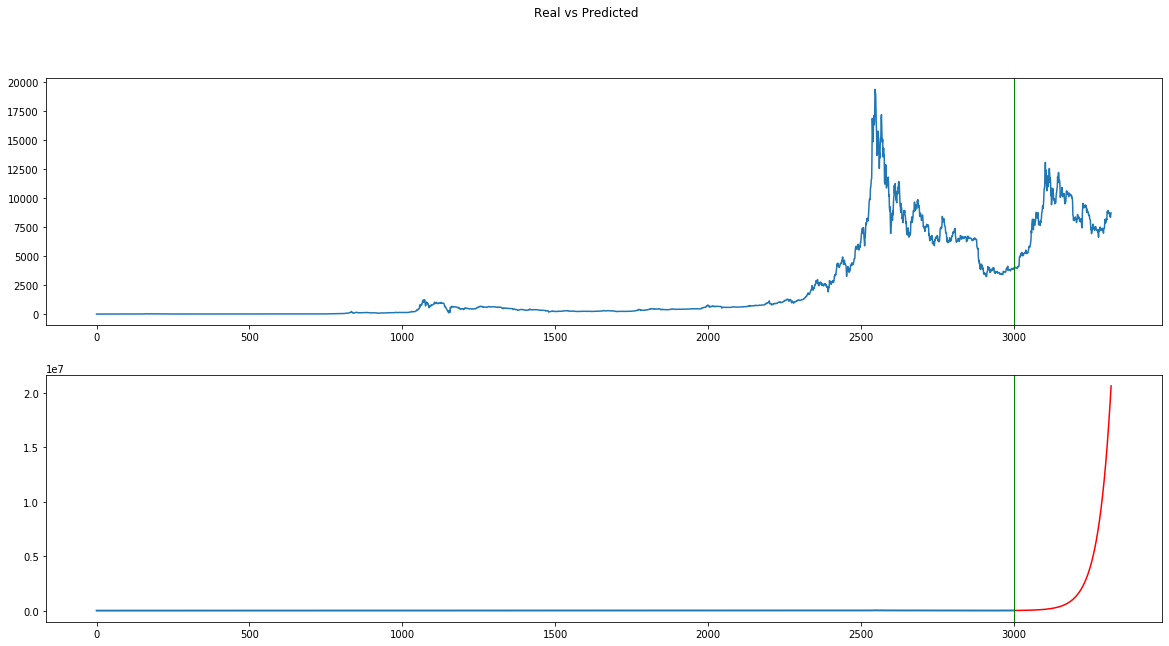

In [11]:
full_pred=np.concatenate((X_train,future_predictions))
full_price=X[:,0]


fig, (ax1, ax2) = plt.subplots(2,figsize=(20,10))
fig.suptitle('Real vs Predicted')

ax1.plot(X[:,0])

ax2.plot(full_pred[:,0],color="red")
ax2.plot(X_train[:,0])


ax1.axvline(x=3000, linewidth=1, color='g')
ax2.axvline(x=3000, linewidth=1, color='g')

That's the problem I was referring to earlier. My net has learnt that if the price arose in the past 7 days, it should go upwards. Therefore, if the first 7 predictions are upwards, this will feedback the net making the price prediction explode (according to my net, by 27th of January 1 BTC would cost 20 million dollars, pretty inaccurate I'd say)

# Final Thoughts

As I said, this was not a financial investment exercise, but more of a basic LSTM introduction. Although the fit on test is not bad, we can see that Bitcoin price is not such an easy time series to predict with unknown data.

We could try different architectures or use some finantial indicators as input variables. Maybe incorporate some new information or just use present data, since btc has evolved a lot since the old times.


Another good idea from statistical time series models such as ARIMAs (which I do know of from my university lessons but haven't tried for bitcoin) is to make the time series stationary (no trend and homogeneous variance).

Maybe I make a series out of this experience trying to improve my model and learn new things about forecasting time series.